# Определение стоимости автомобилей

**Задача:** Построить модель для определения стоимости автомобиля. Основные критерии для модели качество предсказания, скорость предсказания, время обучения.

**Цель:** Разработать приложение для определения стоимости автомобиля и для привлечения новых клиентов.

**Исторические данные:** технические характеристики, комплектации и цены автомобилей

**Действия:**
Предподготовка данных. Построить несколько моделей и на основании основных критериев выбрать оптимальную модель

## Подготовка данных

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statistics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as ltb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# загрузим данные для анализа

data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# проверим данные

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# приведем все названия к нижнему регистру

data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [5]:
data[data.duplicated()].head()  # 4 строчки дубликатов, удалим их

data = data.drop_duplicates()

In [6]:
# проверим даты. База выгружалась за период до '2016-04-07 14:36:58'

q = data['date_crawled'].sort_values()
q.unique()

array(['2016-03-05 14:06:22', '2016-03-05 14:06:23',
       '2016-03-05 14:06:24', ..., '2016-04-07 14:36:55',
       '2016-04-07 14:36:56', '2016-04-07 14:36:58'], dtype=object)

In [7]:
# года регистрации автомобиля неадекватные. Встречаются 1000 и 1600 года, когда автомобилей не было.
# Не будем рассматривать раритет, а возьмем авто с 1975 года по 2016 год, год выгрузки данной базы

s=data['registration_year'].sort_values() 
s.unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [8]:
data = data[(data['registration_year'] <2017) & (data['registration_year'] > 1974)] # фильтрация по годам
data = data[~((data['registration_year'] == 2016) & (data['registration_month'] > 4))] # фильтрация до 04/2016

# всего осталось 332752 позиции

In [9]:
# проверим в каком процентном соотношении пропуски в данных

round(data.isna().sum()/len(data)*100, 2)

date_crawled           0.00
price                  0.00
vehicle_type           5.37
registration_year      0.00
gearbox                5.08
power                  0.00
model                  4.92
kilometer              0.00
registration_month     0.00
fuel_type              7.44
brand                  0.00
repaired              18.63
date_created           0.00
number_of_pictures     0.00
postal_code            0.00
last_seen              0.00
dtype: float64

In [10]:
# в датасете имеется много пропусков в типе данных object, поэтому средним или медианным значениями данные не заполнить, но мы можем заполнить их модей
# попытаемся заполнить пропуски по группировке. Проверим имеются ли скрытые дубикаты в моделях и брендах

unique_model = data['model'].sort_values() # 
unique_model.unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [11]:
unique_model = data['brand'].sort_values() # 
unique_model.unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [12]:
# дополним все данные по модели модей используя полные данные по бренду и году
# после имея данные по бренду и модели заполним тип кузова, тип топлива и коробки передач

def fill_with_mode(column, column1, column2):
    data[column] = data.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "empty")))

In [13]:
fill_with_mode('model', 'brand', 'registration_year')
fill_with_mode('fuel_type', 'brand', 'model')
fill_with_mode('vehicle_type', 'brand', 'model')
fill_with_mode('gearbox', 'brand', 'model')

In [14]:
# удалим все строчки, где не удалось модой внести данные (это приблизительно 2700позиций)

data = data[data['model'] != "empty"]
data = data[data['fuel_type'] != "empty"]
data = data[data['vehicle_type'] != "empty"]
data = data[data['gearbox'] != "empty"]

In [15]:
# проверим осталось ли что-то с 'empty'
data[data=='empty'].sum()


date_crawled            0
price                 0.0
vehicle_type            0
registration_year     0.0
gearbox                 0
power                 0.0
model                   0
kilometer             0.0
registration_month    0.0
fuel_type               0
brand                   0
repaired                0
date_created            0
number_of_pictures    0.0
postal_code           0.0
last_seen               0
dtype: object

In [16]:
# проверим оставшиеся пропуски

round(data.isna().sum()/len(data)*100, 2)

date_crawled           0.00
price                  0.00
vehicle_type           0.00
registration_year      0.00
gearbox                0.00
power                  0.00
model                  0.00
kilometer              0.00
registration_month     0.00
fuel_type              0.00
brand                  0.00
repaired              18.48
date_created           0.00
number_of_pictures     0.00
postal_code            0.00
last_seen              0.00
dtype: float64

In [17]:
# В колонке Repaired тип данных по сути bool и можно предположить, что отсутствующие данные могут быть знаком, что машина после ремонта. 
# Но так как данных в датасете много, то лучше удалить все данные с пропуском, чтоб избежать возможного искаженния данных  

data = data.dropna(subset=['repaired'])

In [18]:
# после удаления пропусков, осталось 269087 данных. Этого достаточно чтоб далее произвести обучение модели
# переведем данные  repaired в числовой тип, т.е 0 или 1

data['repaired'].value_counts()

no     235167
yes     33920
Name: repaired, dtype: int64

In [19]:
data['was_repair'] = 0
data.loc[data['repaired'] == 'yes', 'was_repair'] = 1
data['was_repair'].value_counts()

0    235167
1     33920
Name: was_repair, dtype: int64

In [20]:
data['number_of_pictures'].value_counts()

# все значения нулевые. Колонка неинформативная, нужно ее удалить

0    269087
Name: number_of_pictures, dtype: int64

In [21]:
# переведем данные  Gearbox в числовой тип, т.е 0 или 1

data['gearbox'].value_counts()

manual    214182
auto       54905
Name: gearbox, dtype: int64

In [22]:
data['manual_gearbox'] = 0
data.loc[data['gearbox'] == 'manual', 'manual_gearbox'] = 1
data['manual_gearbox'].value_counts()

1    214182
0     54905
Name: manual_gearbox, dtype: int64

In [23]:
# удалим лишние данные, чтоб они не тормозили модель при обучении и предсказании - это бренд, ктр является аналогом модели, даты, индексы, кол-во фото, которое равно 0 и т.д)

data = data.drop(['date_crawled', 'registration_month', 'brand', 'postal_code', 'date_created', 'last_seen', 'number_of_pictures'], axis=1)

In [24]:
#  выведем статистические показатели наших числовых признаков/
# И проверим снова данные на анамалии или выбрасы - имеются минимальные данные на прайсе и мощности, что анамально

data.describe()

,price,registration_year,power,kilometer,was_repair,manual_gearbox
count,269087.000000,269087.000000,269087.000000,269087.000000,269087.000000,269087.000000
mean,4904.352871,2002.984585,117.361731,127870.186966,0.126056,0.795958
std,4660.675116,5.869797,161.161491,36917.470961,0.331913,0.403000
min,0.000000,1975.000000,0.000000,5000.000000,0.000000,0.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,0.000000,1.000000
50%,3200.000000,2003.000000,109.000000,150000.000000,0.000000,1.000000
75%,7000.000000,2007.000000,150.000000,150000.000000,0.000000,1.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,1.000000,1.000000


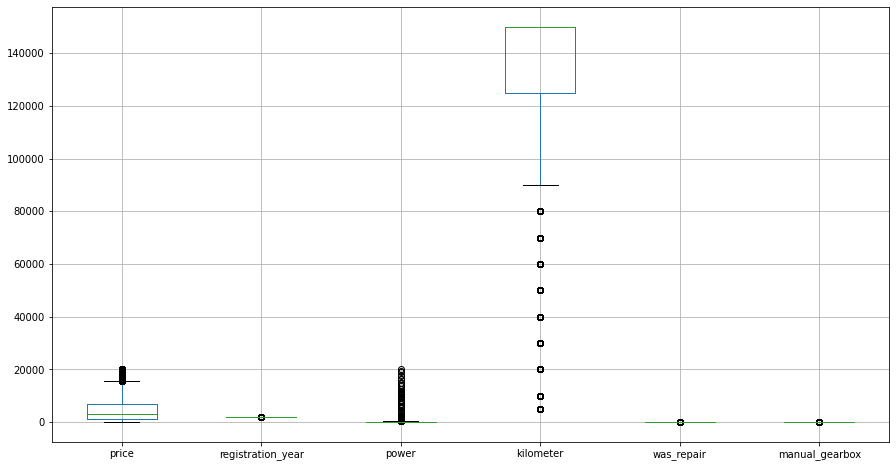

In [25]:
# построим ящик с усами, чтоб увидеть выбросы

data.boxplot(figsize=(15, 8));

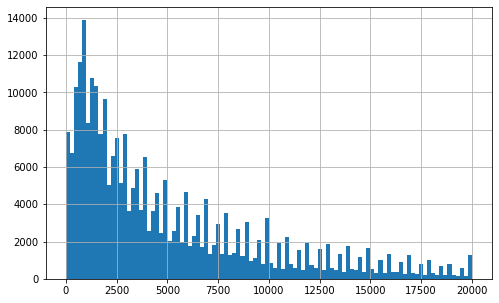

In [26]:
data['price'].hist(bins=100, figsize=(8,5))
plt.show()

In [27]:
data['price'].value_counts() # цены с нулевым показателем удаляем
data = data[data['price'] > 0]


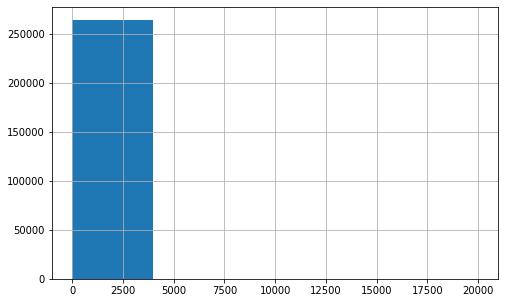

In [28]:
data['power'].hist(bins=5, figsize=(8,5))
plt.show()

In [29]:
# в данных имеется мощность равная 0, это анамально. Удалим все данные ниже 40 и выше 1000

data = data[(data['power'] > 40) & (data['power'] < 1000)]

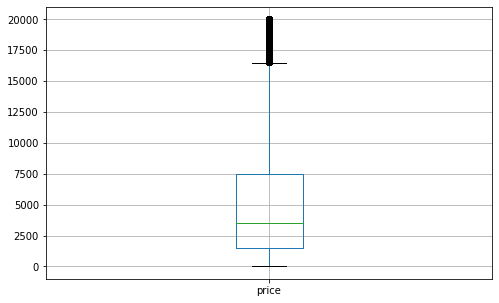

In [30]:
# везде имеются выбросы. Но мы не можем удалить выбросы у признаков автомобиля, 
#потому что уникальность не отменяет того факта, что похожие данные будет использовать пользователь для определения стоимости своего авто
# а вот выброс в цене мы можем регулировать. Удалим из анализируемого датасета выбросы в цене 
data.boxplot('price', figsize=(8, 5));

In [31]:
data = data[data['price'] < 17000]

In [32]:
# проверим корреляцию между признаками и целевым признаком Price

lst = ['registration_year', 'power', 'kilometer', 'manual_gearbox', 'was_repair']

for i in lst:
    print(data['price'].corr(data[i]))
    

0.5965794241940675
0.48160942357304276
-0.3723301396040438
-0.22899660529452107
-0.23326232916554757


### Вывод
В данных было обнаружено большое кол-во пропусков. Пропуски были в данных типа bool или object. Пропуски признаков заполнили mode в большинстве колонок. А вот пропуски в колонке Ремонт пришлось удалить, чтоб они не исказили данные модели. 

Обнаруженные дубликат удалены (4 строчки)

Некоторые колонки не представляли ценности для модели или были неинформативны ('DateCrawled', 'RegistrationMonth', 'PostalCode', 'LastSeen', 'NumberOfPictures', 'Brand'), поэтому их удалили, чтоб лишние данные не влияли на время работы обучения и прогнозирование модели.

Колонки Gearbox	и Repaired перевели в числовие признаки, т.е. 0 и 1, чтоб эти признаки так же были в обучающей модели.
В колонках Price и Power были анамальные данные, а именно нулевые показатели, что не может быть, поэтому они были удалены. Также были удалены выбрасы по цене.

В итоге после всей подготовки данных из 354369 позиций осталось 241255. Это приблизительно на 32% меньше исходных данных, но зато мы будем уверены, что в модели будут присутствовать оптимальные данные для модели, да и оставшихся данных более чем достаточно.

## Обучение моделей

In [33]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired,was_repair,manual_gearbox
3,1500,small,2001,manual,75,golf,150000,petrol,no,0,1
4,3600,small,2008,manual,69,fabia,90000,gasoline,no,0,1
5,650,sedan,1995,manual,102,3er,150000,petrol,yes,1,1
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,no,0,1
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,no,0,1


In [34]:
# обозначим числовые признаки и целевой признак

features = data.drop(['price', 'repaired', 'gearbox'], axis=1)

target = data['price']

In [35]:
#разделим данные на обучающую и тестовую выборки. Затем обучающую разделим на обучающую и валидационную. Проверим верность разбивки

features_train_total, features_test, target_train_total, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train_total, target_train_total, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(135705, 8)
(45236, 8)
(60314, 8)
(135705,)
(45236,)
(60314,)


```python
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]
```

### Линейная регрессия

In [36]:
# произведем прямое кодирование признаков. Применим технику ОНЕ, чтоб качественные признаки сделать количественными для модели

features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [37]:
# Найдем общие признаки между обучающей, валидационной и тестовой выборками

common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

In [38]:
# Оставим в каждой выборке только общие признаки

features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [39]:
# по индексу сгруппируем закодированные признаки для выборок

ohe_features_train = features_train_ohe.loc[features_train.index, :]
ohe_features_valid = features_valid_ohe.loc[features_valid.index, :]
ohe_features_test = features_test_ohe.loc[features_test.index, :]

In [40]:
%%time

# время обучения

model_LR = LinearRegression()
model_LR.fit(ohe_features_train, target_train)

CPU times: user 9.01 s, sys: 2.73 s, total: 11.7 s
Wall time: 11.7 s


LinearRegression()

In [41]:
%%time

# время предсказания

predicted_LR = model_LR.predict(ohe_features_valid)
rmse_LR = (mean_squared_error(target_valid, predicted_LR))**0.5
print(f'RMSE линейной регрессии: {rmse_LR}')
print(f'Время работы:')


RMSE линейной регрессии: 2240.713693470715
Время работы:
CPU times: user 71.6 ms, sys: 107 ms, total: 178 ms
Wall time: 147 ms


### Дерево решений

In [42]:
# произведем порядковое кодирование путем OE

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['vehicle_type', 'model', 'fuel_type', 'was_repair', 'manual_gearbox']
encoder.fit(features_train[cat_columns])



OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

In [43]:
features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])


In [44]:
"""
Определим оптимальные параметры для обучения и закомментируем результат
%%time

# определим оптимальные параметры для модели

best_model = None
best_result = 2500
best_depth = 0
for depth in range(1, 6):
    model_TR = DecisionTreeRegressor(random_state=12345, max_depth=depth)# инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model_TR.fit(ohe_features_train, target_train) # обучим модель на тренировочной выборке    
    predictions_TR = model_TR.predict(ohe_features_train) # получим предсказания модели для выборки
    result = (mean_squared_error(target_train, predictions_TR))**0.5 # посчитаем значение метрики rmse на выборке
    if result < best_result:
        best_model = model_TR
        best_result = result
        best_depth = depth

print(f'RMSE наилучшей модели Дерева решений: {best_result}, Глубина дерева: {best_depth}')
print(f'Время работы:')
"""

"\nОпределим оптимальные параметры для обучения и закомментируем результат\n%%time\n\n# определим оптимальные параметры для модели\n\nbest_model = None\nbest_result = 2500\nbest_depth = 0\nfor depth in range(1, 6):\n    model_TR = DecisionTreeRegressor(random_state=12345, max_depth=depth)# инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth\n    model_TR.fit(ohe_features_train, target_train) # обучим модель на тренировочной выборке    \n    predictions_TR = model_TR.predict(ohe_features_train) # получим предсказания модели для выборки\n    result = (mean_squared_error(target_train, predictions_TR))**0.5 # посчитаем значение метрики rmse на выборке\n    if result < best_result:\n        best_model = model_TR\n        best_result = result\n        best_depth = depth\n\nprint(f'RMSE наилучшей модели Дерева решений: {best_result}, Глубина дерева: {best_depth}')\nprint(f'Время работы:')\n"

In [45]:
%%time

# время обучения

model_TR = DecisionTreeRegressor(random_state=12345, max_depth=5)
model_TR.fit(features_train_ord, target_train)  


CPU times: user 171 ms, sys: 10.8 ms, total: 181 ms
Wall time: 179 ms


DecisionTreeRegressor(max_depth=5, random_state=12345)

In [46]:
%%time

# время предсказания

predictions_TR = model_TR.predict(features_valid_ord) 
rmse_TR = (mean_squared_error(target_valid, predictions_TR))**0.5 
print(f'RMSE наилучшей модели Дерева решений: {rmse_TR}')
print(f'Время работы:')


RMSE наилучшей модели Дерева решений: 2168.387017375911
Время работы:
CPU times: user 9 ms, sys: 888 µs, total: 9.89 ms
Wall time: 10.4 ms


### CatBoostRegressor

In [47]:
%%time

# время обучения

model_CBR = CatBoostRegressor(learning_rate=0.5, random_state=12345, verbose=False) # инициализируем модель
model_CBR.fit(ohe_features_train, target_train) # обучим модель


CPU times: user 20.5 s, sys: 89.7 ms, total: 20.6 s
Wall time: 21.7 s


In [48]:
%%time

# время предсказания

predicted_CBR = model_CBR.predict(ohe_features_valid)
rmse_CBR = (mean_squared_error(target_valid, predicted_CBR))**0.5
print(f'RMSE CatBoostRegressor: {rmse_CBR}')
print(f'Время работы:')

RMSE CatBoostRegressor: 1412.4780007345041
Время работы:
CPU times: user 111 ms, sys: 4.12 ms, total: 115 ms
Wall time: 113 ms


### LightGBM

In [49]:
#LGBMRegressor работает только с категориальными признаками, поэтому создадим таблицу только с ними и закодируем признаки через OE:

features_lgbm = data.drop(['price', 'was_repair', 'manual_gearbox'], axis=1)

target_lgbm = data['price']

In [50]:
#разделим данные на обучающую и тестовую выборки, а затме обучающую разобьем на обучающую и валидационную

features_lgbm_train_total, features_lgbm_test, target_lgbm_train_total, target_lgbm_test = train_test_split(features_lgbm, target_lgbm, test_size=0.25, random_state=12345)
features_lgbm_train, features_lgbm_valid, target_lgbm_train, target_lgbm_valid = train_test_split(features_lgbm_train_total, target_lgbm_train_total, test_size=0.25, random_state=12345)


In [51]:
encoder = OrdinalEncoder()

oe_features_train = features_lgbm_train[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']]
oe_features_train = pd.DataFrame(encoder.fit_transform(features_lgbm_train),
                                 columns=features_lgbm_train.columns,
                                 index=features_lgbm_train.index)

oe_features_valid = features_lgbm_test[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']]
oe_features_valid = pd.DataFrame(encoder.fit_transform(features_lgbm_valid),
                                columns=features_lgbm_valid.columns,
                                index=features_lgbm_valid.index)

oe_features_test = features_lgbm_test[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']]
oe_features_test = pd.DataFrame(encoder.fit_transform(features_lgbm_test),
                                columns=features_lgbm_test.columns,
                                index=features_lgbm_test.index)

oe_target_train = target_lgbm_train
oe_target_valid = target_lgbm_valid
oe_target_test = target_lgbm_test

In [52]:
"""
Автоматически определим наилучшие параметры для модели.
закомментируем данные, чтоб избежать очередного обрабатывания данных

%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, oe_target_train)

print(clf.best_params_)

_______________
{'learning_rate': 0.3, 'num_leaves': 200}
CPU times: user 7min 44s, sys: 11.7 s, total: 7min 55s
Wall time: 7min 59s
"""

"\nАвтоматически определим наилучшие параметры для модели.\nзакомментируем данные, чтоб избежать очередного обрабатывания данных\n\n%%time\n\nmodel_lgbmr = LGBMRegressor() \nparameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5]}]\n\nclf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')\nclf.fit(oe_features_train, oe_target_train)\n\nprint(clf.best_params_)\n\n_______________\n{'learning_rate': 0.3, 'num_leaves': 200}\nCPU times: user 7min 44s, sys: 11.7 s, total: 7min 55s\nWall time: 7min 59s\n"

In [53]:
%%time

# обучение 

model_lgbmr = LGBMRegressor(learning_rate = 0.3, num_leaves = 200) 
model_lgbmr.fit(oe_features_train, oe_target_train)

CPU times: user 8.7 s, sys: 60.5 ms, total: 8.76 s
Wall time: 8.86 s


LGBMRegressor(learning_rate=0.3, num_leaves=200)

In [54]:
%%time

#предсказание

predict_lgbmr = model_lgbmr.predict(oe_features_valid)
rmse_lgbmr = (mean_squared_error(oe_target_valid, predict_lgbmr))**0.5
print(f'RMSE LightGBM: {rmse_lgbmr}')
print(f'Время работы:')

RMSE LightGBM: 1774.5027451274982
Время работы:
CPU times: user 481 ms, sys: 0 ns, total: 481 ms
Wall time: 491 ms


### Вывод
Все четыре модели показали RMSE < 2500, что соответствует требованиям условия. Далее построим сводную таблицу для сравнения полученных данных.

## Анализ моделей

In [55]:
# созданим сводную таблицу данных

index = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LightGBM']
df_model = {'RMSE': [rmse_LR, rmse_TR, rmse_CBR, rmse_lgbmr],
        'Время обучения, сек': [12.9 , 0.111, 17.5, 86],
        'Время предсказания модели, сек': [0.175, 0.008, 0.106, 0.414]}
df_model = pd.DataFrame(data=df_model, index=index)
df_model['Общее время'] = df_model['Время обучения, сек'] + df_model['Время предсказания модели, сек']
df_model

,RMSE,"Время обучения, сек","Время предсказания модели, сек",Общее время
LinearRegression,2240.713693,12.900,0.175,13.075
DecisionTreeRegressor,2168.387017,0.111,0.008,0.119
CatBoostRegressor,1412.478001,17.500,0.106,17.606
LightGBM,1774.502745,86.000,0.414,86.414


### Вывод:
Было построенно 4 модели LinearRegression, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor.
Все четыре модели показали RMSE < 2500, что соответсвует условию. Но также было условие, чтоб время обучения и предсказания были невысокими. Самая быстрая модель (около 2 сек) оказалась DecisionTreeRegressor, но при этом RMSE самое высокое, что говорит о низком качестве модели по сравнению с др. моделями. Если выбирать оптимальный вариант по качеству и времени, то самая точная модель CatBoostRegressor (RMSE = 1421), а время обработки у нее не самое высокое (всего 17,6 сек).


## Тестирование лучшей модели

In [59]:
%%time

# время предсказания на тестовой выборке CatBoostRegressor

predicted_CBR_test = model_CBR.predict(ohe_features_test)
rmse_CBR_test = (mean_squared_error(target_test, predicted_CBR_test))**0.5
print(f'RMSE CatBoostRegressor: {rmse_CBR}')
print(f'Время работы:')

RMSE CatBoostRegressor: 1412.4780007345041
Время работы:
CPU times: user 135 ms, sys: 4.09 ms, total: 139 ms
Wall time: 138 ms


### Вывод
Прогнав все модели на тестовых выборках, мы получила подтверждение предположения, что оптимальный вариант для анализа стоимости автомобиля модель CatBoostRegressor, так как данная модель дает самый точный результат за среднее время.